In [183]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import random
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import json
import matplotlib.pyplot as plt
# Optional: thêm XGBoost và LightGBM nếu dùng
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [184]:
class ModelManager:
    """Quản lý các model và cấu hình của chúng"""
    
    @staticmethod
    def get_model(model_type='RF', **kwargs):
        """
        Tạo và trả về một cặp model cho forward và backward prediction
        
        Parameters:
        -----------
        model_type : str
            Loại model ('RF', 'XGB', 'LGBM', 'SVR', 'LR')
        **kwargs : dict
            Các tham số bổ sung cho model
        """
        default_params = {
            'RF': {'n_estimators': 100, 'random_state': 42},
            'XGB': {'n_estimators': 100, 'learning_rate': 0.1, 'random_state': 42},
            'LGBM': {'n_estimators': 100, 'learning_rate': 0.1, 'random_state': 42, 'verbosity': -1},
            'SVR': {'C':1.0, 'kernel':'rbf'},
            'LR': {}
        }
        
        # Kết hợp default params với kwargs
        params = {**default_params.get(model_type, {}), **kwargs}
        
        if model_type == 'RF':
            model_f = RandomForestRegressor(**params)
            model_b = RandomForestRegressor(**params)
        elif model_type == 'XGB':
            model_f = XGBRegressor(**params)
            model_b = XGBRegressor(**params)
        elif model_type == 'LGBM':
            model_f = LGBMRegressor(**params)
            model_b = LGBMRegressor(**params)
        elif model_type == 'SVR':
            model_f = SVR(**params)
            model_b = SVR(**params)
        elif model_type == 'LR':
            model_f = LinearRegression(**params)
            model_b = LinearRegression(**params)
        else:
            raise ValueError(f"Model type '{model_type}' is not supported.")
            
        return model_f, model_b


In [185]:

def remove_outliers_iqr(data, threshold=3.0):
    """
    Replace outliers (outside Q1 - threshold*IQR and Q3 + threshold*IQR)
    with mean of non-outlier values.
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    
    mask = (data >= lower_bound) & (data <= upper_bound)
    mean_value = data[mask].mean()
    
    clean_data = np.where(mask, data, mean_value)
    return clean_data
def min_max_scale(data):
    """
    Scale data to range [0, 1] and return scaled data with inverse function.
    """
    data_min = np.min(data)
    data_max = np.max(data)
    
    
    scaled = (data - data_min) / (data_max - data_min)
    
    def inverse(scaled_data):
        
        return scaled_data * (data_max - data_min) + data_min
    
    return scaled, inverse


In [186]:


# def get_model(model_type='RF'):
#     if model_type == 'RF':
#         model_f = RandomForestRegressor(n_estimators=100, random_state=42)
#         model_b = RandomForestRegressor(n_estimators=100, random_state=42)
#     elif model_type == 'XGB':
#         model_f = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
#         model_b = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
#     elif model_type == 'LGBM':
#         model_f = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)
#         model_b = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)
#     elif model_type == 'SVR':
#         model_f = SVR(C=1.0, epsilon=0.1, kernel='rbf', gamma='scale')
#         model_b = SVR(C=1.0, epsilon=0.1, kernel='rbf', gamma='scale')

#     elif model_type == 'LR':
#         model_f = LinearRegression()
#         model_b = LinearRegression()
#     else:
#         raise ValueError(f"Model type '{model_type}' is not supported.")
#     return model_f, model_b

def create_multiple_gaps(data_length, gap_size, num_gaps=1, mode='size'):
    """
    mode='size': gap_size là số lượng phần tử (int)
    mode='ratio': gap_size là phần trăm dữ liệu (float, ví dụ 0.02)
    """
    positions = []
    for _ in range(num_gaps):
        if mode == 'ratio':
            size = int(data_length * gap_size)
        else:
            size = gap_size
        if size >= data_length:
            raise ValueError("Gap size too large compared to data length.")
        start = random.randint(0, data_length - size)
        positions.extend(range(start, start + size))
    return sorted(set(positions)), size

def to_supervised(data, T):
    X, y = [], []
    for i in range(T, len(data)):
        if not np.isnan(data[i]) and not np.isnan(data[i-T:i]).any():
            X.append(data[i-T:i])
            y.append(data[i])
    return np.array(X), np.array(y)

import numpy as np
from sklearn.metrics import mean_absolute_error

def impute_gap(data, missing_positions, T, model_type='RF', model_params=None, combination_method='weighted'):
    data_imputed = data.copy()
    N = len(data)
    gaps = []
    current_gap = []

    for i in range(len(data)):
        if i in missing_positions:
            current_gap.append(i)
        else:
            if current_gap:
                gaps.append(current_gap)
                current_gap = []
    if current_gap:
        gaps.append(current_gap)

    for gap in gaps:
        start = gap[0]
        end = gap[-1]

        Db = data_imputed[:start]
        Da = data_imputed[end+1:]

        Xf, yf = to_supervised(Db, T)
        Xb, yb = to_supervised(Da[::-1], T)

        # Khởi tạo model
        model_params = model_params or {}
        model_f, model_b = ModelManager.get_model(model_type, **model_params)
        # model_f, model_b = get_model(model_type)

        use_forward = False
        use_backward = False
        if start < 5*T:
            use_backward = True
        elif end > N - 5*T:
            use_forward = True
        else:
            use_forward = True
            use_backward = True

        x_fc, x_bc = [], []

        if use_forward and len(Xf) > 0 and len(Db) >= T:
            model_f.fit(Xf, yf)
            last_known = Db[-T:]
            for _ in range(len(gap)):
                if np.isnan(last_known).any():
                    break
                pred = model_f.predict([last_known])[0]
                x_fc.append(pred)
                last_known = np.roll(last_known, -1)
                last_known[-1] = pred

        if use_backward and len(Xb) > 0 and len(Da) >= T:
            model_b.fit(Xb, yb)
            last_known_b = Da[:T][::-1]
            for _ in range(len(gap)):
                if np.isnan(last_known_b).any():
                    break
                pred_b = model_b.predict([last_known_b])[0]
                x_bc.append(pred_b)
                last_known_b = np.roll(last_known_b, -1)
                last_known_b[-1] = pred_b
            x_bc = x_bc[::-1]



        if combination_method == 'map_error':
            val_len = min(10, len(Xf), len(Xb))
            pred_f = model_f.predict(Xf[-val_len:]) if use_forward and len(Xf) >= val_len else []
            pred_b = model_b.predict(Xb[-val_len:]) if use_backward and len(Xb) >= val_len else []
            
            true_f = yf[-val_len:] if len(yf) >= val_len else []
            true_b = yb[-val_len:] if len(yb) >= val_len else []
            
            error_f = mean_absolute_error(true_f, pred_f) if len(pred_f) > 0 else np.inf
            error_b = mean_absolute_error(true_b, pred_b) if len(pred_b) > 0 else np.inf

            if np.isfinite(error_f) and np.isfinite(error_b):
                wf = 1 / error_f
                wb = 1 / error_b
                wf = wf / (wf + wb)
                wb = 1 - wf
            else:
                wf = wb = 0.5
        elif combination_method == 'weighted':  # đây là MEOW
            margin = 0.1  # hệ số mềm

        # Điền các giá trị đã dự đoán
        L = len(gap)  # độ dài gap
        for idx, pos in enumerate(gap):
            f_val = x_fc[idx] if idx < len(x_fc) else np.nan
            b_val = x_bc[idx] if idx < len(x_bc) else np.nan

            if use_forward and use_backward:
                if not np.isnan(f_val) and not np.isnan(b_val):
                    if combination_method == 'weighted':
                        # MEOW: tính trọng số theo vị trí
                        alpha = -(1 / L) * idx * (1 - 2 * margin) + (1 - margin)
                        data_imputed[pos] = alpha * f_val + (1 - alpha) * b_val
                    elif combination_method == 'map_error':
                            data_imputed[pos] = wf * f_val + wb * b_val
                    else:
                        data_imputed[pos] = (f_val + b_val) / 2
                elif not np.isnan(f_val):
                    data_imputed[pos] = f_val
                elif not np.isnan(b_val):
                    data_imputed[pos] = b_val
            elif use_forward and not np.isnan(f_val):
                data_imputed[pos] = f_val
            elif use_backward and not np.isnan(b_val):
                data_imputed[pos] = b_val
            else:
                data_imputed[pos] = np.nan

        return data_imputed

def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Fractional Bias
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    fb = 2 * abs((mean_pred - mean_true) / (mean_pred + mean_true))
    
    # Fractional Standard Deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    fsd = 2 * abs((sd_true - sd_pred) / (sd_true + sd_pred))
    
    # Similarity
    T = len(y_true)
    range_x = np.max(y_true) - np.min(y_true)
    if range_x == 0:
        sim = 1.0 if np.allclose(y_true, y_pred) else 0.0
    else:
        diff_sum = np.sum(1/(1+(np.abs(y_true - y_pred) / range_x)))
        sim = diff_sum / T
        
    return {'SIM': sim, 'MAE': mae, 'RMSE': rmse, 'FB': fb, 'FSD': fsd}




def plot_imputation_results(original, processed_original, data_missing, imputed_data, gap_input,missing_positions):
    # Biểu đồ 1: Dữ liệu gốc đã xử lý
    plt.figure(figsize=(14, 4))
    plt.plot(processed_original, label='Original Data (Processed)', color='gray')
    plt.title(f"Original Data (Processed) (Gap={gap_input})")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Biểu đồ 2: Dữ liệu có missing (NaNs)
    plt.figure(figsize=(14, 4))
    plt.plot(data_missing, label='With Missing (NaNs)', color='red', linestyle='dotted')
    plt.title(f"Data with Missing Values (Gap={gap_input})")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # # Biểu đồ 3: Dữ liệu sau khi imputation
    # plt.figure(figsize=(14, 4))
    # plt.plot(imputed_data, label='Imputed Data', color='blue')
    # plt.title(f"Imputed Data (Gap={gap_input})")
    # plt.xlabel("Time Index")
    # plt.ylabel("Value")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    # Biểu đồ 4: So sánh dữ liệu gốc vs dữ liệu đã điền
    plt.figure(figsize=(20, 4))
    plt.plot(original[missing_positions], label='Original Data', color='gray')
    plt.plot(imputed_data[missing_positions], label='Imputed Data', color='blue', linestyle='dashed',alpha=0.3)
    plt.title(f"Comparison: Original vs Imputed (Gap={gap_input})")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [187]:
def run_pipeline(data, gap_inputs, input_type='size', num_runs=10, model_type='RF', 
                remove_outliers=True, scale_data=True, outlier_threshold=3.0, fixed_positions=None, 
                combination_method='weighted', T=None):
    """
    Complete pipeline including preprocessing and imputation
    
    Parameters:
    -----------
    data : array-like
        Input time series data
    gap_inputs : list
        List of gap sizes or ratios
    input_type : str, optional (default='size')
        'size' for number of elements or 'ratio' for percentage
    num_runs : int, optional (default=10)
        Number of experiment runs
    model_type : str, optional (default='RF')
        Type of model to use ('RF', 'XGB', 'LGBM', 'SVR', 'LR')
    remove_outliers : bool, optional (default=True)
        Whether to remove outliers using IQR method
    scale_data : bool, optional (default=True)
        Whether to scale data to [0,1] range
    outlier_threshold : float, optional (default=3.0)
        Threshold for IQR outlier removal
    fixed_positions : dict, optional (default=None)
        Dictionary of pre-generated gap positions for each gap_input and run
    combination_method : str, optional (default='weighted')
        Method to combine forward and backward predictions ('simple', 'weighted', 'exp')
    T : int, optional (default=None)
        Window size for prediction. If None, uses 3*gap_size
    """
    # Preprocessing
    processed_data = data.copy()
    
    if remove_outliers:
        processed_data = remove_outliers_iqr(processed_data, threshold=outlier_threshold)
    
    if scale_data:
        processed_data, inverse_scale = min_max_scale(processed_data)
    
    # Generate or use fixed gap positions
    if fixed_positions is None:
        gap_positions = {}
        for gap_input in gap_inputs:
            gap_positions[gap_input] = {}
            for run in range(num_runs):
                positions, size = create_multiple_gaps(len(processed_data), gap_input, 
                                                    num_gaps=1, mode=input_type)
                gap_positions[gap_input][run] = (positions, size)
    else:
        gap_positions = fixed_positions
    
    # Run experiments
    all_results = []
    for gap_input in gap_inputs:
        print(f"\n==> Gap:", gap_input*100 if input_type=='ratio' else gap_input)
        results = []

        for run in tqdm(range(num_runs), desc="Running imputations"):
            data_missing = processed_data.copy()
            missing_positions, gap_size = gap_positions[gap_input][run]
            
            # Create gaps
            for pos in missing_positions:
                data_missing[pos] = np.nan

            # Use provided T or default to 3*gap_size
            window_size = T if T is not None else 3*gap_size
            
            # Impute
            imputed_data = impute_gap(data_missing, missing_positions, T=window_size, 
                                    model_type=model_type, combination_method=combination_method)

            # Transform back if scaled
            if scale_data:
                imputed_data = inverse_scale(imputed_data)

            # Evaluate
            y_true = data[missing_positions]
            y_pred = imputed_data[missing_positions]
            score = evaluate_metrics(y_true, y_pred)
            results.append(score)

        # Average results
        avg_score = {k: np.mean([r[k] for r in results]) for k in results[0]}
        all_results.append((gap_input, avg_score))
        print(f"→ Average metrics: {avg_score}")

    return all_results, gap_positions

def run_multiple_models(data, gap_inputs, model_types, input_type='size', num_runs=10,
                       remove_outliers=True, scale_data=True, outlier_threshold=3.0, 
                       fixed_positions=None, combination_method='weighted', T=None):
    """
    Run multiple models with the same gap positions for fair comparison
    
    Parameters are same as run_pipeline
    """
    results = {}
    i = 0
    if fixed_positions is None:
        i = 1
        # First run to generate gap position
        first_model = model_types[0]
        print(f"\n=========={first_model} Results==========")
        model_results, gap_positions = run_pipeline(
            data=data,
            gap_inputs=gap_inputs,
            input_type=input_type,
            num_runs=num_runs,
            model_type=first_model,
            remove_outliers=remove_outliers,
            scale_data=scale_data,
            outlier_threshold=outlier_threshold,
            combination_method=combination_method,
            T=T
        )
        results[first_model] = model_results
    else:
        gap_positions = fixed_positions
        
    # Run remaining models with same gap positions
    for model_type in model_types[i:]:
        print(f"\n=========={model_type} Results==========")
        model_results, _ = run_pipeline(
            data=data,
            gap_inputs=gap_inputs,
            input_type=input_type,
            num_runs=num_runs,
            model_type=model_type,
            remove_outliers=remove_outliers,
            scale_data=scale_data,
            outlier_threshold=outlier_threshold,
            fixed_positions=gap_positions,
            combination_method=combination_method,
            T=T
        )
        results[model_type] = model_results
    
    return {
        'results': results,
        'gap_positions': gap_positions
    }


In [188]:
# Đọc dữ liệu txt mỗi dòng 1 số
data_batri = np.loadtxt(r'D:\Learn\Kì 5\DPL302m\Dataset\batri_temp.txt')
gap_sizes = [0.006, 0.0075, 0.01, 0.0125, 0.015]
model_type_list = [ 'SVR','RF','LGBM','LR', 'XGB']



In [189]:
with open(r"D:\Learn\Kì 5\DPL302m\CODE\batri_gap_positions.json", "r") as f:
    batri_fixed_positions = json.load(f)

# Chuyển key string → float + int (nếu cần)
batri_fixed_positions = {
    float(gap): {int(run): (positions, size)
        for run, (positions, size) in run_dict.items()}
    for gap, run_dict in batri_fixed_positions.items()
}


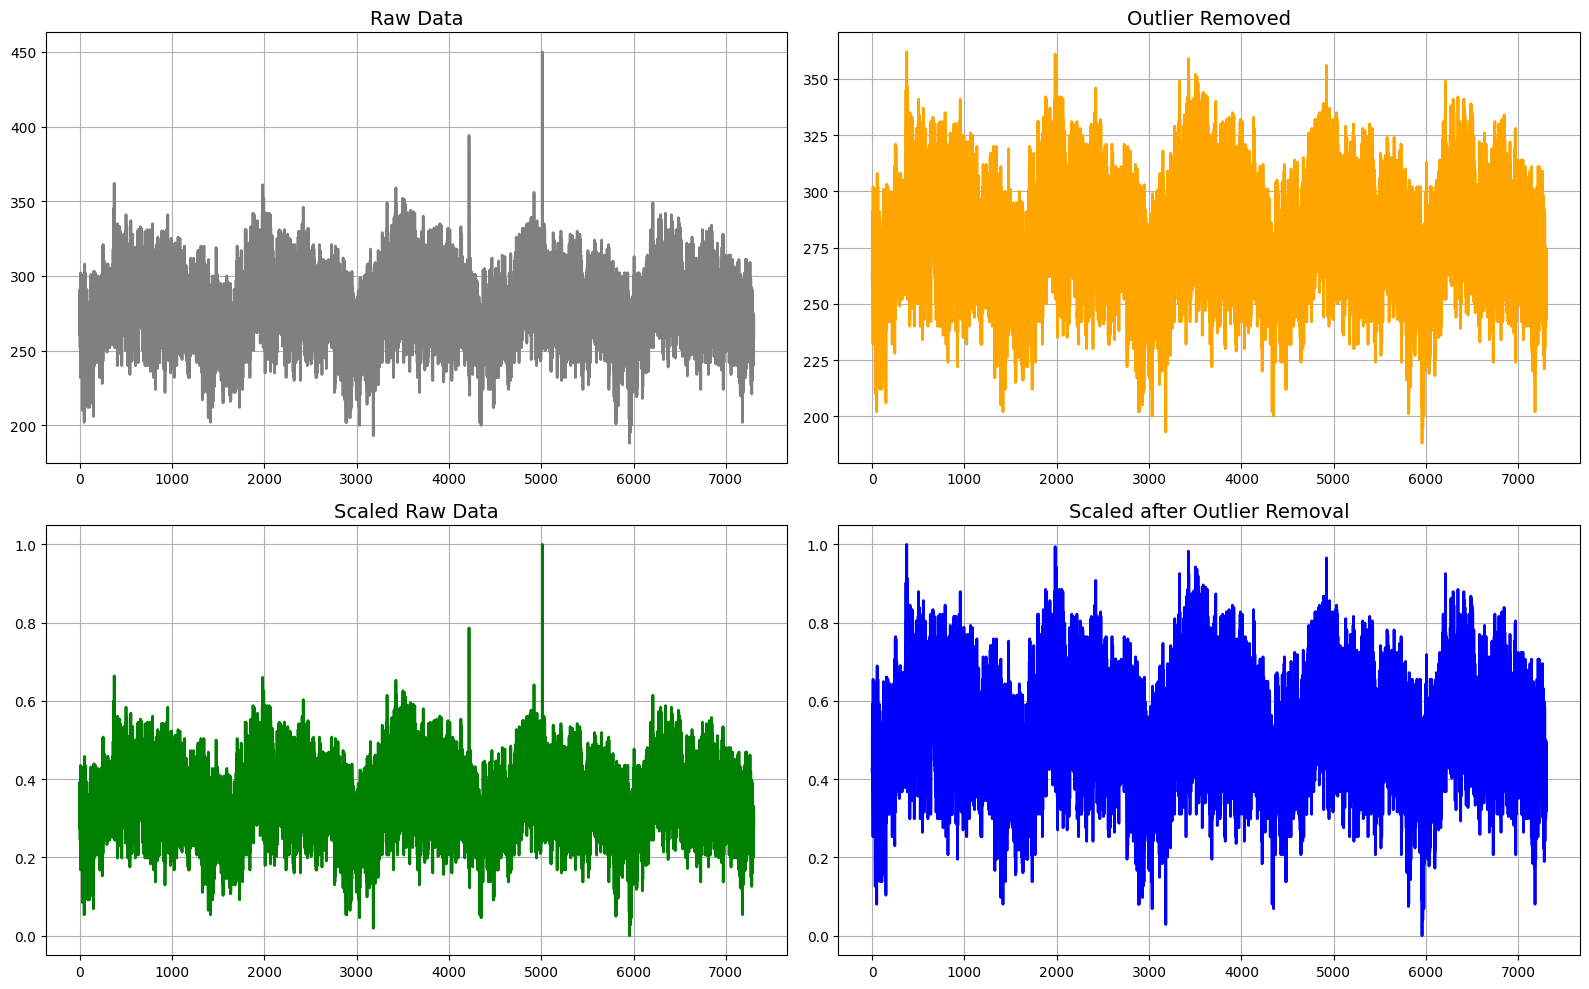

In [190]:

# Apply both steps
data_raw = data_batri
data_clean = remove_outliers_iqr(data_raw)
data_scaled,_ = min_max_scale(data_raw)
data_clean_scaled,_ = min_max_scale(data_clean)

plt.figure(figsize=(16, 10))

# 1. Raw Data
plt.subplot(2, 2, 1)
plt.plot(data_raw, color='gray', linewidth=2)
plt.title("Raw Data", fontsize=14)
plt.grid(True)

# 2. Outlier Removed
plt.subplot(2, 2, 2)
plt.plot(data_clean, color='orange', linewidth=2)
plt.title("Outlier Removed", fontsize=14)
plt.grid(True)

# 3. Scaled Raw Data
plt.subplot(2, 2, 3)
plt.plot(data_scaled.ravel(), color='green', linewidth=2)
plt.title("Scaled Raw Data", fontsize=14)
plt.grid(True)

# 4. Scaled after Outlier Removal
plt.subplot(2, 2, 4)
plt.plot(data_clean_scaled.ravel(), color='blue', linewidth=2)
plt.title("Scaled after Outlier Removal", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()




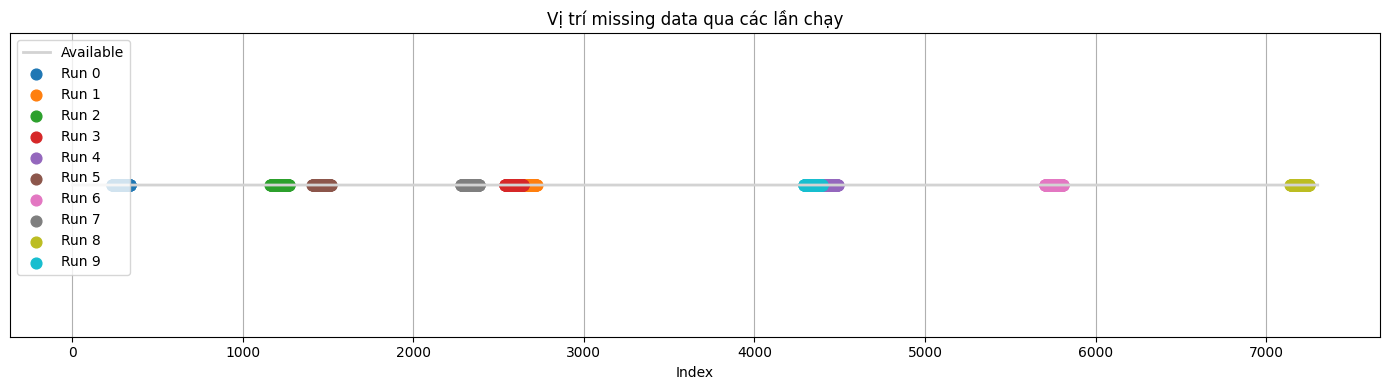

In [191]:
# Vẽ các vị trí missing cho từng lần chạy
plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(data_batri)), np.ones_like(data_batri), color='lightgray', label='Available', linewidth=2)


for run_idx, (run, (miss_idxs, miss_len)) in enumerate(batri_fixed_positions[0.015].items()):
    plt.scatter(miss_idxs, np.ones_like(miss_idxs), label=f"Run {run}", s=60)

plt.title("Vị trí missing data qua các lần chạy")
plt.xlabel("Index")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Run model Batri

In [192]:
all_results = run_multiple_models(
    data=data_batri,
    gap_inputs=gap_sizes,
    model_types=model_type_list,
    input_type='ratio',
    remove_outliers=True,
    scale_data=True,
    fixed_positions=batri_fixed_positions,
    combination_method='map_error'
)


==========SVR Results==========

==> Gap: 0.6


Running imputations:  80%|████████  | 8/10 [00:02<00:00,  3.75it/s]


KeyboardInterrupt: 

In [8]:
all_results['gap_positions'][0.006]

{0: ([1843,
   1844,
   1845,
   1846,
   1847,
   1848,
   1849,
   1850,
   1851,
   1852,
   1853,
   1854,
   1855,
   1856,
   1857,
   1858,
   1859,
   1860,
   1861,
   1862,
   1863,
   1864,
   1865,
   1866,
   1867,
   1868,
   1869,
   1870,
   1871,
   1872,
   1873,
   1874,
   1875,
   1876,
   1877,
   1878,
   1879,
   1880,
   1881,
   1882,
   1883,
   1884,
   1885],
  43),
 1: ([2105,
   2106,
   2107,
   2108,
   2109,
   2110,
   2111,
   2112,
   2113,
   2114,
   2115,
   2116,
   2117,
   2118,
   2119,
   2120,
   2121,
   2122,
   2123,
   2124,
   2125,
   2126,
   2127,
   2128,
   2129,
   2130,
   2131,
   2132,
   2133,
   2134,
   2135,
   2136,
   2137,
   2138,
   2139,
   2140,
   2141,
   2142,
   2143,
   2144,
   2145,
   2146,
   2147],
  43),
 2: ([5248,
   5249,
   5250,
   5251,
   5252,
   5253,
   5254,
   5255,
   5256,
   5257,
   5258,
   5259,
   5260,
   5261,
   5262,
   5263,
   5264,
   5265,
   5266,
   5267,
   5268,
   5269,
   

In [9]:

with open("gap_positions.json", "w") as f:
    json.dump(all_results['gap_positions'], f, indent=2, ensure_ascii=False)


In [10]:
with open("gap_positions.json", "r") as f:
    data = json.load(f)
print(data)

{'0.006': {'0': [[1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885], 43], '1': [[2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147], 43], '2': [[5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290], 43], '3': [[821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854,

In [154]:
gap_lens = [6,9,12,15,18]
# Giả sử df là DataFrame với index là năm và cột là tháng
df = pd.read_csv(r"D:\Learn\Kì 5\DPL302m\Dataset\PhuLien_bochoi.csv", index_col=0)  # hoặc dùng read_excel
df = df.sort_index()  # đảm bảo theo năm tăng dần

# Chuyển thành chuỗi 1 chiều
ts = df.values.flatten()  # thành mảng numpy 1D
ts=ts[:-3]
# ts


In [155]:
with open(r"D:\Learn\Kì 5\DPL302m\CODE\PhuLien_bochoi_gap_positions.json", "r") as f:
    Phulien_fixed_positions = json.load(f)

# Chuyển key string → float + int (nếu cần)
Phulien_fixed_positions = {
    float(gap): {int(run): (positions, size)
        for run, (positions, size) in run_dict.items()}
    for gap, run_dict in Phulien_fixed_positions.items()
}
print(Phulien_fixed_positions)

{6.0: {0: ([105, 106, 107, 108, 109, 110], 6), 1: ([446, 447, 448, 449, 450, 451], 6), 2: ([512, 513, 514, 515, 516, 517], 6), 3: ([518, 519, 520, 521, 522, 523], 6), 4: ([528, 529, 530, 531, 532, 533], 6), 5: ([469, 470, 471, 472, 473, 474], 6), 6: ([498, 499, 500, 501, 502, 503], 6), 7: ([55, 56, 57, 58, 59, 60], 6), 8: ([409, 410, 411, 412, 413, 414], 6), 9: ([25, 26, 27, 28, 29, 30], 6)}, 9.0: {0: ([186, 187, 188, 189, 190, 191, 192, 193, 194], 9), 1: ([423, 424, 425, 426, 427, 428, 429, 430, 431], 9), 2: ([134, 135, 136, 137, 138, 139, 140, 141, 142], 9), 3: ([290, 291, 292, 293, 294, 295, 296, 297, 298], 9), 4: ([429, 430, 431, 432, 433, 434, 435, 436, 437], 9), 5: ([224, 225, 226, 227, 228, 229, 230, 231, 232], 9), 6: ([67, 68, 69, 70, 71, 72, 73, 74, 75], 9), 7: ([283, 284, 285, 286, 287, 288, 289, 290, 291], 9), 8: ([399, 400, 401, 402, 403, 404, 405, 406, 407], 9), 9: ([261, 262, 263, 264, 265, 266, 267, 268, 269], 9)}, 12.0: {0: ([350, 351, 352, 353, 354, 355, 356, 357, 358,

# Run model PhuLienBocHoi

In [193]:
all_results = run_multiple_models(
    data=ts,
    gap_inputs=gap_lens,
    model_types=model_type_list,
    input_type='size',
    remove_outliers=True,
    scale_data=True,
    fixed_positions=Phulien_fixed_positions,
    combination_method='weighted'
)


==========SVR Results==========

==> Gap: 6


Running imputations: 100%|██████████| 10/10 [00:00<00:00, 96.01it/s]


→ Average metrics: {'SIM': 0.8294863579407918, 'MAE': 12.009053898784265, 'RMSE': 15.317592918950467, 'FB': 0.13339456574911152, 'FSD': 0.4518481091115114}

==> Gap: 9


Running imputations: 100%|██████████| 10/10 [00:00<00:00, 139.29it/s]


→ Average metrics: {'SIM': 0.8492160079226545, 'MAE': 14.510301774814192, 'RMSE': 20.103454345799644, 'FB': 0.17266382265796726, 'FSD': 0.39055586383509366}

==> Gap: 12


Running imputations: 100%|██████████| 10/10 [00:00<00:00, 147.59it/s]


→ Average metrics: {'SIM': 0.8759355697957375, 'MAE': 11.202396876813411, 'RMSE': 14.435301384598384, 'FB': 0.08436710128864934, 'FSD': 0.3822526445978281}

==> Gap: 15


Running imputations: 100%|██████████| 10/10 [00:00<00:00, 145.32it/s]


→ Average metrics: {'SIM': 0.8658326805478517, 'MAE': 11.646358448537203, 'RMSE': 14.157889199558094, 'FB': 0.0563196328282385, 'FSD': 0.38739289125765164}

==> Gap: 18


Running imputations: 100%|██████████| 10/10 [00:00<00:00, 156.85it/s]


→ Average metrics: {'SIM': 0.8720776070059223, 'MAE': 13.370244439784798, 'RMSE': 18.979312918807214, 'FB': 0.12577544778599184, 'FSD': 0.4087061140418101}

==========RF Results==========

==> Gap: 6


Running imputations: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


→ Average metrics: {'SIM': 0.843659899366544, 'MAE': 10.6799110890198, 'RMSE': 13.611758547237311, 'FB': 0.10407406950922582, 'FSD': 0.5500047623753884}

==> Gap: 9


Running imputations: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


→ Average metrics: {'SIM': 0.8469015960044268, 'MAE': 14.833578471063111, 'RMSE': 20.503574346654155, 'FB': 0.15565173689123016, 'FSD': 0.4734894288605466}

==> Gap: 12


Running imputations:  20%|██        | 2/10 [00:02<00:09,  1.14s/it]


KeyboardInterrupt: 

In [77]:
import json

with open("PhuLien_bochoi_gap_positions.json", "w") as f:
    json.dump(all_results['gap_positions'], f, indent=2, ensure_ascii=False)
